In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [ ]:
from google.colab import drive
input_path = "../content/DATA_CHAMBER_2021/"
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=False)
model.classifier = nn.Linear(2208, 3)
# fine tuning

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [ ]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [ ]:
model = model.to(device)

In [ ]:
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 840/840train loss: 0.5586, acc: 0.7579
Duration :498.9837951660156 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 840/840train loss: 0.1164, acc: 0.9623
Duration :498.1301167011261 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 840/840train loss: 0.0631, acc: 0.9790
Duration :498.46833205223083 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 840/840train loss: 0.0512, acc: 0.9830
Duration :499.3327555656433 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 840/840train loss: 0.0301, acc: 0.9908
Duration :500.7376444339752 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 840/840train loss: 0.0301, acc: 0.9905
Duration :499.99225068092346 seconds
--------------------

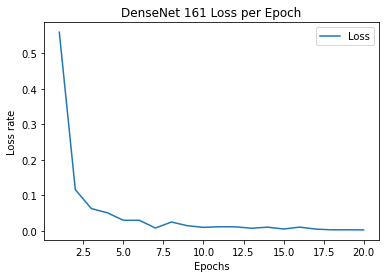

In [ ]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("DenseNet 161 Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
print(lossLine)

[0.5586124036227625, 0.11637186021978711, 0.0630660523926068, 0.05124498184329988, 0.030109725137928308, 0.03006896114476883, 0.008411162536103732, 0.025265220243328484, 0.014812389113665074, 0.010294473255436903, 0.011940047736536107, 0.011701070619395907, 0.007779591244959475, 0.010821786103755135, 0.005626613555266086, 0.010912747584206557, 0.005424037496662184, 0.0033042374903766367, 0.0034766675206096788, 0.003071625298067519]


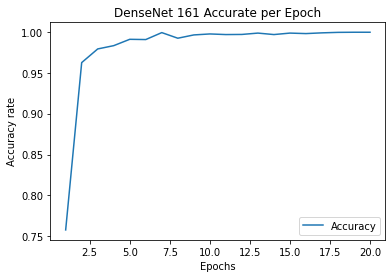

In [ ]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("DenseNet 161 Accurate per Epoch")
plt.legend()
plt.show()

In [ ]:
print(accLine)

[tensor(0.7579, device='cuda:0', dtype=torch.float64), tensor(0.9623, device='cuda:0', dtype=torch.float64), tensor(0.9790, device='cuda:0', dtype=torch.float64), tensor(0.9830, device='cuda:0', dtype=torch.float64), tensor(0.9908, device='cuda:0', dtype=torch.float64), tensor(0.9905, device='cuda:0', dtype=torch.float64), tensor(0.9990, device='cuda:0', dtype=torch.float64), tensor(0.9921, device='cuda:0', dtype=torch.float64), tensor(0.9961, device='cuda:0', dtype=torch.float64), tensor(0.9973, device='cuda:0', dtype=torch.float64), tensor(0.9966, device='cuda:0', dtype=torch.float64), tensor(0.9967, device='cuda:0', dtype=torch.float64), tensor(0.9984, device='cuda:0', dtype=torch.float64), tensor(0.9966, device='cuda:0', dtype=torch.float64), tensor(0.9984, device='cuda:0', dtype=torch.float64), tensor(0.9978, device='cuda:0', dtype=torch.float64), tensor(0.9987, device='cuda:0', dtype=torch.float64), tensor(0.9993, device='cuda:0', dtype=torch.float64), tensor(0.9994, device='cuda

In [ ]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

              0
0  10272.895508


In [ ]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       409
           1       0.81      0.91      0.86       367
           2       0.96      0.91      0.93       831

    accuracy                           0.91      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.91      0.91      0.91      1607



0.9066583696328563

In [ ]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [ ]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 158 label: 0 pred: 0
vid: 167 label: 2 pred: 2
vid: 170 label: 2 pred: 2
vid: 190 label: 1 pred: 1
vid: 180 label: 2 pred: 2
vid: 194 label: 1 pred: 1
vid: 188 label: 2 pred: 2
vid: 176 label: 0 pred: 0
vid: 191 label: 0 pred: 0
vid: 183 label: 0 pred: 0
vid: 162 label: 1 pred: 1
vid: 184 label: 2 pred: 2
vid: 163 label: 2 pred: 2
vid: 185 label: 1 pred: 1
vid: 195 label: 2 pred: 2
vid: 166 label: 1 pred: 1
vid: 165 label: 0 pred: 0
vid: 179 label: 1 pred: 1
vid: 181 label: 0 pred: 2
vid: 186 label: 1 pred: 1
vid: 187 label: 2 pred: 2
vid: 175 label: 1 pred: 1
vid: 172 label: 2 pred: 2
vid: 171 label: 0 pred: 0
vid: 168 label: 0 pred: 0
vid: 161 label: 1 pred: 1
vid: 178 label: 0 pred: 0
vid: 182 label: 2 pred: 2
vid: 173 label: 2 pred: 2
vid: 169 label: 0 pred: 0
vid: 189 label: 1 pred: 1
vid: 177 label: 0 pred: 0
vid: 192 label: 0 pred: 0
vid: 157 label: 1 pred: 1
vid: 160 label: 2 pred: 1
vid: 164 label: 2 pred: 2
vid: 159 label: 1 pred: 1
vid: 193 label: 2 pred: 2
vid: 174 lab

In [ ]:
accuracy_score(y_true,y_pred)

0.9230769230769231